<a href="https://colab.research.google.com/github/tikendraw/Amazon-review-sentiment-analysis/blob/main/amazon-review-sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Reviews for Sentiment Analysis

## Objective

Here we will be Building ML and DL models to predict the Polarity of reviews.
We will be performing series of experiments with different models to achieve the best classification metrics.(while not abusing the machine we have)

## About Dataset 
[Dataset here](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews)


### OVERVIEW
Contains 34,686,770 Amazon reviews from 6,643,669 users on 2,441,053 products, from the Stanford Network Analysis Project (SNAP). This subset contains 1,800,000 training samples and 200,000 testing samples in each polarity sentiment.

### ORIGIN
The Amazon reviews dataset consists of reviews from amazon. The data span a period of 18 years, including ~35 million reviews up to March 2013. Reviews include product and user information, ratings, and a plaintext review. For more information, please refer to the following paper: J. McAuley and J. Leskovec. Hidden factors and hidden topics: understanding rating dimensions with review text. RecSys, 2013.

### DESCRIPTION
The Amazon reviews polarity dataset is constructed by taking review score 1 and 2 as negative, and 4 and 5 as positive. Samples of score 3 is ignored. In the dataset, class 1 is the negative and class 2 is the positive. Each class has 1,800,000 training samples and 200,000 testing samples.

If you need help extracting the train.csv and test.csv files check out the starter code.

The files train.csv and test.csv contain all the training samples as comma-separated values.

The CSVs contain polarity, title, text. These 3 columns in them, correspond to class index (1 or 2), review title and review text.

polarity - 1 for negative and 2 for positive
title - review heading
text - review body
The review title and text are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

In [1]:
# ! git clone https://github.com/tikendraw/funcyou.git -q
# ! pip install funcyou/
# ! rm -rf funcyou
# ! pip install tensorflow_hub

In [2]:
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Embedding ,LSTM, Dense, Dropout, TextVectorization
import matplotlib.pyplot as plt
import polars as pl
import tensorflow_hub as hub
import os, re, json
import tensorflow as tf
#preprocessing functions to clear punctuations, lower strings, remove special chars removing contractions
from funcyou.preprocessing.text import  text_cleaning_apos, cont_to_exp, text_cleaning
import sys
import pandas as pd
from pathlib import Path
import pickle
import tarfile
# importing useful functions
from funcyou.sklearn.metrics import calculate_results
from funcyou.plot import plot_history, compare_histories

print('Tf version: ',tf.__version__)
print('GPU: ',len(tf.config.list_physical_devices('GPU')))

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TFHUB_CACHE_DIR"] = './tmp/tfhub'


use_url = 'https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz'


2023-08-29 19:17:56.522350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 19:17:57.869527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tf version:  2.12.1
GPU:  0


2023-08-29 19:18:01.025882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-29 19:18:01.062207: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
import numpy as np
import random
import tensorflow as tf
import torch
import pandas as pd
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
import polars as pl

In [4]:
def set_global_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    global random_state
    random_state = check_random_state(seed)


# Set the seed value
SEED = 42 # should be same as seed in config file

# Call the function to set the seeds
set_global_seed(SEED)


In [5]:
cur_dir = Path(os.getcwd())
model_dir = Path(os.getcwd()).parent /'model'

In [6]:
data_dir = Path(os.getcwd()).parent /'dataset'
data_dir

PosixPath('/home/t/aproject/Amazon-review-sentiment-analysis/dataset')

In [7]:
def download_USEncoder():

    try:
        print('downloading universal sentence encoder...')
        use_filename = wget.download(use_url)

        print('Downloaded!')
        # Extracting
        os.makedirs('universal_sentence_encoder', exist_ok = True)
        print('Extracting universal sentence encoder....')
        # open file
        file = tarfile.open(use_filename)
        
        # extracting file
        file.extractall('./universal_sentence_encoder')
        
        file.close()
        print('Extracted.')
    except Exception as e:
        print(e)


In [8]:
# Download the data if you don't have locally
data_url = 'https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews'

def download_data(data_url):
    download_kaggle_dataset(url = data_url)
    print('Dataset Downloaded.')

    import zipfile
    with zipfile.ZipFile('./amazon-reviews.zip', 'r') as zip_ref:
        zip_ref.extractall('./dataset')
    print('Extracted.')




In [9]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    download_USEncoder()
    download = input('Did you upload kaggle.json?(Yes/No) ')
    if download in ['yes','Yes','Y','y']:
        print('Dataset Downloading...')
        download_data(data_url)
    
else:
  print('Not running on CoLab')


Not running on CoLab


In [10]:
# embed = hub.KerasLayer("../universal_sentence_encoder")

# Load the data

In [10]:
#reading data
df = pl.read_csv(data_dir/'train.csv',new_columns = ['polarity', 'title','text'])  # gives TextFileReader, which is iterable with chunks of 1000 rows.


In [11]:
df.describe()

describe,polarity,title,text
str,f64,str,str
"""count""",3.599999e6,"""3599999""","""3599999"""
"""null_count""",0.0,"""0""","""0"""
"""mean""",1.5,null,null
"""std""",0.5,null,null
"""min""",1.0,"""""","""this is the b…"
"""max""",2.0,"""♦ LOVE IT ♦""","""…were Marvin a…"
"""median""",1.0,null,null
"""25%""",1.0,null,null
"""75%""",2.0,null,null


In [13]:
# check for nulls and drop if any
df.null_count()

polarity,title,text
u32,u32,u32
0,0,0


In [14]:
#drop nulls
df.drop_nulls()
print()

In [15]:
# checking for classs imbalance
df['polarity'].value_counts()

polarity,counts
i64,u32
1,1800000
2,1799999


**Note:** The dataset is fairly large, we will use tensorflow's data api to load and handle the data

# We will map the polarity between 0 for negative sentiment to 1 for positive sentiment

In [16]:
df = df.with_columns([
                    pl.col('polarity').apply(lambda x: 0 if x == 1 else 1).alias('polarity')
                     ])

df = df.with_columns([
                     pl.col('polarity').cast(pl.Int16, strict=False).alias('polarity')
                     ])


In [17]:
df.sample(10)

polarity,title,text
i16,str,str
1,"""Classic Advent…","""This book is a…"
1,"""Phenomenal""","""This is a stun…"
0,"""Disappointed""","""When we first …"
1,"""Very Comfortab…","""I got this mat…"
0,"""For the Comple…","""I hate to say …"
1,"""Abbi Loves Thi…","""I haven't even…"
1,"""Another Schwar…","""Same comments …"
1,"""Finally a stap…","""If you have ki…"
1,"""Pixel Chix is …","""I want Pixel C…"


## Note: We will be combining text and title columns . makes more sense.

In [18]:
import seaborn as sns
from collections import Counter
import polars as pl
import re
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from funcyou.preprocessing.text import IntegerVectorizer
from funcyou.plot import distplot_axis

In [19]:
df = df.with_columns([
    (pl.col('title')+' ' + pl.col('text')).alias('review')
])

df = df.with_columns([
    pl.col('review').str.to_lowercase()
])


In [20]:
df = df.with_columns([
    pl.col('title').apply(lambda x: len(str(x).split())).alias('title_len'),
])

df = df.with_columns([
    pl.col('text').apply(lambda x: len(str(x).split())).alias('text_len'),
])

df = df.with_columns([
    pl.col('review').apply(lambda x: len(str(x).split())).alias('review_len')
])


In [21]:
def clean_text(x: str) -> str:
    return re.sub(r'[^\w\s]', ' ', x.lower())  # Remove punctuation after lowring


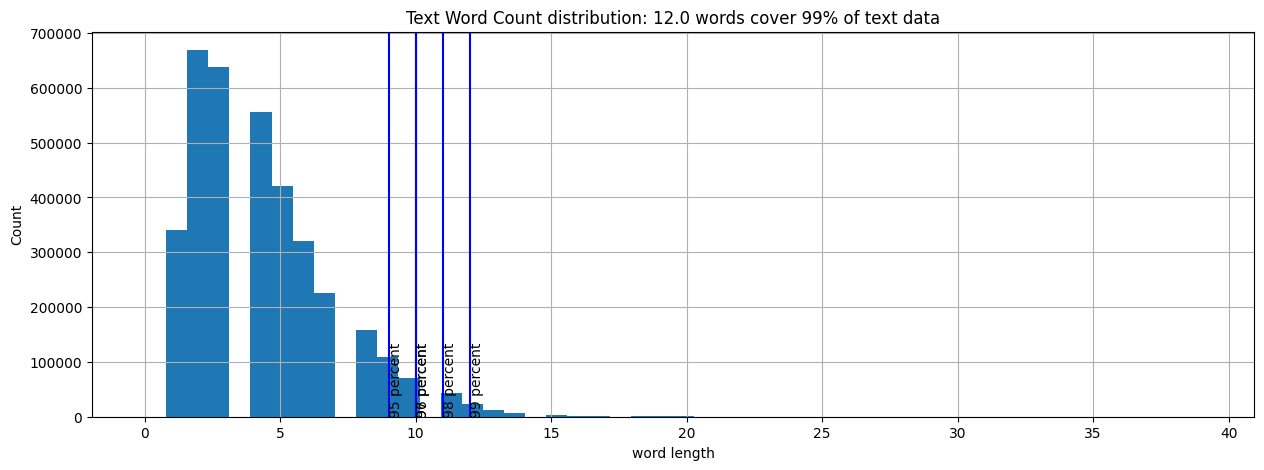

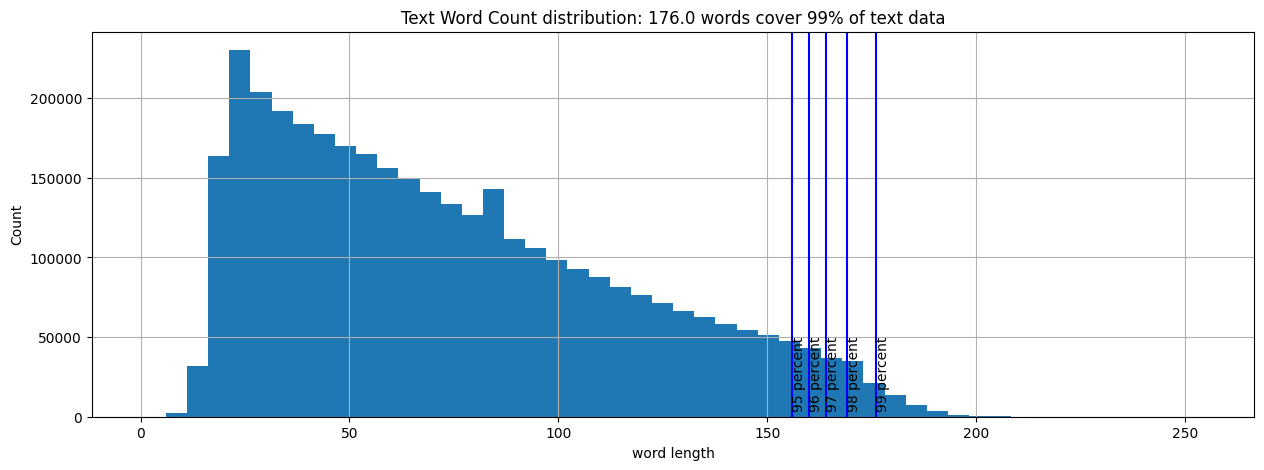

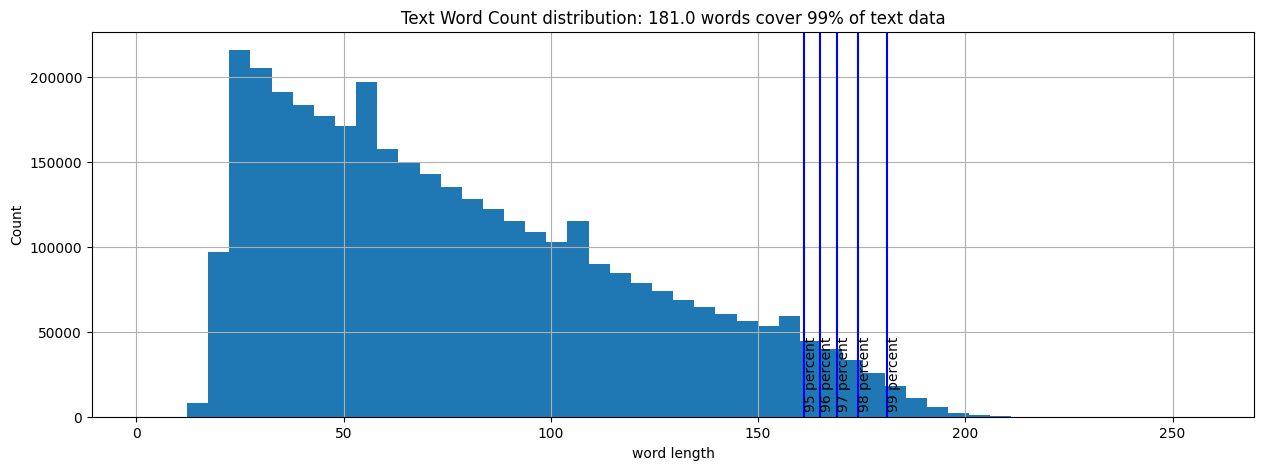

In [22]:

plt.figure(figsize=(15,5))
distplot_axis(df['title_len'].to_numpy())

plt.figure(figsize=(15,5))
distplot_axis(df['text_len'].to_numpy())

plt.figure(figsize=(15,5))
distplot_axis(df['review_len'].to_numpy())

In [23]:
df = df.select(['review', 'polarity'])

In [24]:
df.head()

review,polarity
str,i16
"""the best sound…",1
"""amazing! this …",1
"""excellent soun…",1
"""remember, pull…",1
"""an absolute ma…",1


In [25]:
counter_object_filepath = model_dir / 'counter.pkl'

In [28]:
a = IntegerVectorizer(preprocessing_func=clean_text, min_freq=3) # 5 min
a.adapt(df['review'])

# save the counter object
counter_object = a.vocab.counter

with open(counter_object_filepath, 'wb') as output_file:
    pickle.dump(counter_object, output_file)
    print('file saved at',counter_object_filepath)

Vocab size: 279088
file saved at /home/t/aproject/Amazon-review-sentiment-analysis/model/counter.pkl


In [29]:
a.vocab.vocab_size #  wwe will set max token to 300_000 in text vectorizer

279088

In [32]:
with open(counter_object_filepath, 'rb') as output_file:
    counter_object = pickle.load(output_file)

In [30]:
df.write_csv(data_dir / 'preprocessed_df.csv')

In [31]:
df = pl.read_csv(data_dir/'preprocessed_df.csv')
df.head()

review,polarity
str,i64
"""the best sound…",1
"""amazing! this …",1
"""excellent soun…",1
"""remember, pull…",1
"""an absolute ma…",1


In [32]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1], reverse = False)[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                counter_object: 29.3 MiB
                 MultinomialNB:  1.6 KiB
               TfidfVectorizer:  1.6 KiB
                      Pipeline:  1.6 KiB
                     Embedding:  1.6 KiB
                          LSTM:  1.6 KiB
                         Dense:  1.6 KiB
                       Dropout:  1.6 KiB
             TextVectorization:  1.6 KiB
                       Counter:  1.6 KiB


# Text vectorization

In [33]:
MAX_TOKEN = 300_000
OUTPUT_SEQUENCE_LENGTH = 175  # limiting reviews to 200 words

creating a dictionary of words with counts helps me create text vectorizer alot faster .


it only took 3min 24sec to create the dictionary from 3.6 million entries which is alot faster if you try to 
adapt  TextVectorization to the data.

In [34]:
text_vectorizer = TextVectorization(max_tokens=MAX_TOKEN, standardize='lower_and_strip_punctuation',
                                   split='whitespace',
                                    ngrams= None ,
                                    output_mode='int',
                                    output_sequence_length=OUTPUT_SEQUENCE_LENGTH, 
                                    pad_to_max_tokens=True,
                                    vocabulary = list(counter_object.keys())[:MAX_TOKEN-2]) # -2 FOR 'PAD' AND 'UNK' TOKEN

In [35]:
random_review = 'WHo the duck are you?'

In [36]:
word_to_id = tf.keras.layers.StringLookup(vocabulary=text_vectorizer.get_vocabulary(), mask_token='', oov_token='[UNK]')
id_to_word = tf.keras.layers.StringLookup(vocabulary=text_vectorizer.get_vocabulary(), mask_token='', oov_token='[UNK]', invert=True)

In [37]:
print('random Review: ', random_review)
print('random Review length: ', len(random_review))
print('-------\n')
print('vectorized review: ',text_vectorizer([random_review]))

print('Reverse vectorized review: ',id_to_word(text_vectorizer([random_review])))


print('-------\n')
print('Vocabulary_length: ',len(text_vectorizer.get_vocabulary()))
print('Most frequent words: ',text_vectorizer.get_vocabulary()[:10])
print('least frequent words: ',text_vectorizer.get_vocabulary()[-10:])

random Review:  WHo the duck are you?
random Review length:  21
-------

vectorized review:  tf.Tensor(
[[  92    2 8278   58   57    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0 

# Data Preparation

In [38]:

TEST_SIZE = .01 # same as config.TEST_SIZE

In [39]:
xtrain, xtest, ytrain, ytest = train_test_split( df.select('review'), df.select('polarity'), test_size=  .01,  random_state = SEED)

In [40]:
del(df)

In [41]:
print('xtrain shape',xtrain.shape, 'ytrain shape', ytrain.shape)
print('xtest shape',xtest.shape, 'ytest shape', ytest.shape)

xtrain shape (3563999, 1) ytrain shape (3563999, 1)
xtest shape (36000, 1) ytest shape (36000, 1)


# Creating tensorflow dataset using `tf.data` api

In [42]:
BATCH_SIZE = 32

In [43]:
def data_generator(x, y):
    num_samples = len(x)
    for i in range(num_samples):
        yield x[i], y[i]


def create_datasets(x, y, text_vectorizer, batch_size, shuffle=True, buffer_size=10000):
    
    generator = data_generator(x, y)
    print('Generating...')
    train_dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, x.shape[1]), dtype=tf.string),
            tf.TensorSpec(shape=(None, y.shape[1]), dtype=tf.int32)
        )
    )
    print('Mapping...')
    train_dataset = train_dataset.map(lambda x, y: (tf.cast(text_vectorizer(x), tf.int32)[0], y[0]), tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(batch_size) 
    
    if shuffle:
        train_dataset = train_dataset.shuffle(buffer_size)
    train_dataset = train_dataset.cache().prefetch(tf.data.AUTOTUNE)
    print('Done.')
    return train_dataset


In [44]:
train_dataset = create_datasets(xtrain, ytrain, text_vectorizer, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = create_datasets(xtest, ytest, text_vectorizer, batch_size=BATCH_SIZE, shuffle=False)

Generating...
Mapping...
Done.
Generating...
Mapping...
Done.


In [ ]:
# del(xtrain, ytrain)
# del(xtest, ytest, counter_object)

In [ ]:
# train_features = tf.data.Dataset.from_tensor_slices(xtrain) 
# train_label = tf.data.Dataset.from_tensor_slices(ytrain) 
# test_features = tf.data.Dataset.from_tensor_slices(xtest) 
# test_label = tf.data.Dataset.from_tensor_slices(ytest) 

# del(xtrain, ytrain, xtest, ytest) # deleting variables to free the memory

In [ ]:
# train_dataset = tf.data.Dataset.zip((train_features, train_label))
# train_dataset = train_dataset.map(lambda x,y: (text_vectorizer(x)[0],y),tf.data.AUTOTUNE)
# train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# test_dataset = tf.data.Dataset.zip((test_features, test_label))
# test_dataset = test_dataset.map(lambda x,y: (text_vectorizer(x)[0],y),tf.data.AUTOTUNE )
# test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# del(train_features, train_label, test_features, test_label) # deleting variables to free the memory

In [45]:
print('len train dataset: ', len(train_dataset)) # doesn't work for generator generated tensor data
print('len test dataset: ', len(test_dataset))  # doesn't work for generator generated tensor data


TypeError: The dataset length is unknown.

In [46]:
for i,j in train_dataset:
    print(i.shape,j.shape)
    print(i,j)
    break

2023-08-29 19:48:44.865322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype resource
	 [[{{node Placeholder/_3}}]]
2023-08-29 19:48:44.866135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string
	 [[{{node Placeholder/_5}}]]


(32, 175) (32, 1)
tf.Tensor(
[[  9456     43   1189 ...      0      0      0]
 [    11    400    205 ...      0      0      0]
 [   237    225    420 ...      0      0      0]
 ...
 [  1065     20     43 ...      0      0      0]
 [   418  19531      8 ...      0      0      0]
 [280552   1472     76 ...      0      0      0]], shape=(32, 175), dtype=int32) tf.Tensor(
[[1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]], shape=(32, 1), dtype=int32)


2023-08-29 19:48:45.136808: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [47]:
type(train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [48]:
train_length = xtrain.shape[0]// BATCH_SIZE
test_length = xtest.shape[0] // BATCH_SIZE

In [49]:
print("train length: ", train_length, '\ntest_length: ', test_length)

train length:  111374 
test_length:  1125


In [50]:
VECTORIZE_PATH = cur_dir.parent / 'model' / 'text_vectorizer.pkl'
VECTORIZE_PATH

PosixPath('/home/t/aproject/Amazon-review-sentiment-analysis/model/text_vectorizer.pkl')

In [51]:
# to load text vectorizer

def load_text_vectorizer(vectorizer_path):
    from_disk = pickle.load(open(vectorizer_path, "rb"))
    return TextVectorization.from_config(from_disk['config'])



In [52]:
text_vectorizer.vocabulary_size(), text_vectorizer.get_vocabulary()[:4]

(300000, ['', '[UNK]', 'the', 'best'])

In [54]:
text_vectorizer = load_text_vectorizer(model_dir/'text_vectorizer.pkl')

In [55]:
# Pickle the config and weights
def save_text_vectorizer(vectorizer_path):
    pickle.dump({'config': text_vectorizer.get_config(),
                'vocabulary': text_vectorizer.get_vocabulary()}
                , open(vectorizer_path, "wb"))



In [ ]:
save_text_vectorizer(VECTORIZE_PATH)

# Embedding

In [57]:
DIM = 8

In [58]:
embedding = Embedding(input_dim = MAX_TOKEN,output_dim= DIM, mask_zero=True, input_length=OUTPUT_SEQUENCE_LENGTH)
# print('Embedded text vectorized random sentence: ',embedding(text_vectorizer(random_review)))

# Model:0 (Naive bayes model)

In [59]:
model0 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('multino',MultinomialNB())
])

In [60]:
%%time
#fit and predict
model0.fit(xtrain['review'], ytrain)

/home/t/miniconda3/envs/deep/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 2min 20s, sys: 10.4 s, total: 2min 30s
Wall time: 3min 29s


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('multino', MultinomialNB())])

In [61]:
pred0 = model0.predict(xtest['review'])

print(pred0.shape ==  ytest.shape)
print('pred00.shape: ',pred0.shape)
print('ytest.shape: ',ytest.shape)

model0_res = calculate_results(y_true=ytest, y_pred=pred0, model_name='model0: naive bayes')
print(model0_res)

False
pred00.shape:  (36000,)
ytest.shape:  (36000, 1)
{'model': 'model0: naive bayes', 'accuracy': 84.79444444444444, 'precision': 0.8482905354316962, 'recall': 0.8479444444444444, 'f1': 0.8479237632137091, 'discription': None}


{'model': 'model0: naive bayes', 'accuracy': 84.79444444444444, 'precision': 0.8482905354316962, 'recall': 0.8479444444444444, 'f1': 0.8479237632137091, 'discription': None}

# Model1

In [62]:

def create_lstm_model(input_shape, max_tokens, dim):
    inputs = keras.Input(shape=(input_shape))
    embedding_layer = Embedding(input_dim=max_tokens, output_dim=dim, mask_zero=True, input_length=input_shape, name='embedding_layer')(inputs)
    x = LSTM(16, return_sequences=True, name = 'lstm_layer_1')(embedding_layer)
    x = LSTM(16, name = 'lstm_layer_2')(x)
    x = Dropout(0.4, name ='dropout_layer')(x)
    x = Dense(64, activation='relu', name = 'dense_layer_1')(x)
    outputs = Dense(1, activation='sigmoid', name = 'dense_layer_2_final')(x)
    return keras.Model(inputs=inputs, outputs=outputs, name='model_lstm')



In [63]:
import tensorflow as tf

class LSTMModel(tf.keras.Model):
    def __init__(self, text_vectorizer, embed_dim, dropout_rate=0.2):
        super(LSTMModel, self).__init__(name='custom_lstm_model')
        self.text_vectorizer = text_vectorizer
        
        self.embedding_layer = tf.keras.layers.Embedding(input_dim=text_vectorizer.vocabulary_size(), output_dim=embed_dim)
        self.lstm1 = tf.keras.layers.LSTM(16, return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(16)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dropout(x)
        x = self.dense1(x)
        return self.dense2(x)
         
    
    def predict_text(self, text):
        vectorized_text = self.text_vectorizer.transform([text])
        return self.predict(vectorized_text)


# Instantiate the model
output_sequence_length = OUTPUT_SEQUENCE_LENGTH  # actual value
# model = LSTMModel(text_vectorizer, embed_dim=DIM)
model = create_lstm_model(output_sequence_length, max_tokens=MAX_TOKEN, dim=DIM)

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['Accuracy'])

In [64]:
model.summary()

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 175)]             0         
                                                                 
 embedding_layer (Embedding)  (None, 175, 8)           2400000   
                                                                 
 lstm_layer_1 (LSTM)         (None, 175, 16)           1600      
                                                                 
 lstm_layer_2 (LSTM)         (None, 16)                2112      
                                                                 
 dropout_layer (Dropout)     (None, 16)                0         
                                                                 
 dense_layer_1 (Dense)       (None, 64)                1088      
                                                                 
 dense_layer_2_final (Dense)  (None, 1)                6

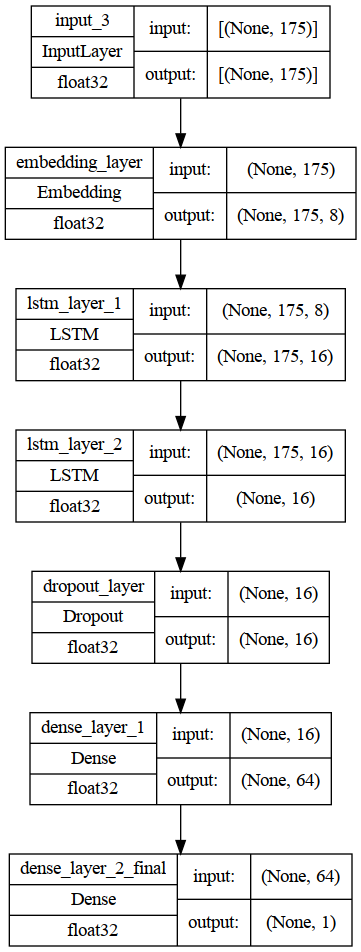

In [51]:
tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True, show_dtype=True, rankdir='TP')

In [67]:
EPOCHS = 1
# print(len(train_dataset), len(val_dataset))

In [68]:
model_dir = Path(os.getcwd()).parent /'model'
model_dir

PosixPath('/home/t/aproject/Amazon-review-sentiment-analysis/model')

In [43]:
model = tf.keras.models.load_model(model_dir/'model.h5')

In [71]:
# %%time

# fit the model
history1 = model.fit(train_dataset, epochs = EPOCHS, 
                      validation_data= test_dataset, 
                      # steps_per_epoch=int(0.001*(len(train_dataset) / EPOCHS)),
                      steps_per_epoch = 1000,
                      # validation_steps=int(1*(len(test_dataset) / EPOCHS)),
                      validation_steps=32,
                    )

 963/1000 [===========================>..] - ETA: 6s - loss: 0.3468 - Accuracy: 0.8600

KeyboardInterrupt: 

In [ ]:
model_dir

In [166]:
model.save_weights(model_dir/'model.h5')

In [ ]:
from funcyou.plot import plot_history

In [ ]:
h1 = pd.DataFrame(history1.history)
h1

In [ ]:
#plot history
# plot_history(history1, plot=['loss','accuracy'], figsize=(15,5))
# plot_training_history(history1, metrics=['loss', 'accuracy'], figsize=(18,3))


#### Evaluation

In [ ]:
ypred1 = tf.squeeze(tf.round(model1.predict(test_dataset)))
print('ypred1.shape: ',ypred1.shape)

model1_res = calculate_results(ytest,ypred1, model_name='model1: LSTM', discription = 'small lstm model with vectorizer and embedding layer')
print(model1_res)


In [ ]:
all_result

In [58]:

def predict_sentiment(title, text, text_vectorizer, lstm_model):
    review = f'{title} {text}' # concatenate the title and text
    clean_review = clean_text(review)
    review_sequence = text_vectorizer([clean_review])
    prediction = lstm_model.predict(review_sequence)
    sentiment_score = prediction[0][0]
    sentiment_label = 'Positive' if sentiment_score >= 0.5 else 'Negative'
    return sentiment_label, sentiment_score


In [59]:
review_title = 'my name is mike'
review_text  =  "and i don't like it"

sentiment_label, sentiment_score = predict_sentiment(review_title, review_text, text_vectorizer, model)
print(sentiment_label, sentiment_score)

1/1 [==============================] - 0s 25ms/step
Positive 0.73981065
